In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

RAND_INIT = 123456

In [2]:
def get_alg(name, k, random_state, max_iter, extra_params={}):
    if name == 'km':
        return KMeans(n_clusters=k, random_state=random_state, max_iter=max_iter, **extra_params)
    elif name == 'gm':
        return GaussianMixture(n_components=k, random_state=random_state, max_iter=max_iter, **extra_params)
    elif name == 'db':
        return DBSCAN(eps=2.4, **extra_params)
    else:
        raise Exception('unknown alg')

In [3]:
def norm_X(df):
    real_X = df.iloc[:, 4:].as_matrix().astype(float)
    
    for i in xrange(real_X.shape[1]):
        col = real_X[:,i]
        col_std = np.std(col)
        col_mean = np.mean(col)
        real_X[:,i] = (col - col_mean) / col_std
        
    return real_X

def tfidf_X(df):
    real_X = df.iloc[:, 4:].as_matrix()
    trf = TfidfTransformer()
    real_X = trf.fit_transform(real_X).toarray()

    return real_X

def norm_tfidf_X(df):
    real_X = df.iloc[:, 4:].as_matrix()
    trf = TfidfTransformer()
    real_X = trf.fit_transform(real_X).toarray()

    for i in xrange(real_X.shape[1]):
        col = real_X[:,i]
        col_std = np.std(col)
        col_mean = np.mean(col)
        real_X[:,i] = (col - col_mean) / col_std

    return real_X

In [4]:
def cls_explore(df, y):
    df_clusters = df.copy()
    df_clusters['cluster'] = y
    interests = df_clusters.columns[4:-1]
    aggs = {key : np.sum for key in interests}
    aggs['cluster'] = {'size': len}

    res = df_clusters.groupby('cluster').agg(aggs)
    res.columns = res.columns.get_level_values(0)

    for interest in interests:
    #     res[interest] = res[interest] / res['cluster'] * 100000
    #     col_std = np.std(res[interest])
    #     col_mean = np.mean(res[interest])
    #     res[interest] = (res[interest] - col_mean) / col_std

        res[interest] = res[interest] / np.sum(res[interest]) / res['cluster'] * 100000
    #     res[interest] = res[interest] / np.sum(res[interest])

    from IPython import display
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display.display(res)

    for i, row in enumerate(res.as_matrix().argsort(axis=1)):
        top_inds = row[::-1][1:6]
        print('Кластер {} : {}'.format(i, ' '.join(res.columns[top_inds])))

In [5]:
def k_plot(X, alg_name, quality, k_start, k_end, random_state, max_iter):
    ks = xrange(k_start, k_end + 1)
    criteria = np.empty(len(ks))

    for i, k in enumerate(ks):
        x = X[:]
        cls = get_alg(alg_name, k=k, random_state=random_state, max_iter=max_iter)
        yl = cls.fit(x).predict(x)
        x, yl = shuffle(x, yl, random_state=RAND_INIT)
        criteria[i] = quality(x[:10000], yl[:10000])

    plt.figure(figsize=(8, 6))
    plt.plot(ks, criteria)
    plt.title("$J(k)$")
    plt.ylabel("Criteria $J$")
    plt.xlabel("Number of clusters $k$")
    plt.grid()
    plt.show()

In [6]:
def quality(x, y):
    x, y = shuffle(x, y, random_state=RAND_INIT)
    return silhouette_score(x[:10000], y[:10000])

In [7]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(df_sns.index[24337])
df_sns = df_sns.drop(df_sns.index[14187])
df_sns = df_sns.drop(df_sns.index[13224])
df_sns = df_sns.drop(df_sns.index[11195])
df_sns = df_sns.drop(df_sns.index[4950])
df_sns = df_sns.drop(df_sns.index[4129])
df_sns = df_sns.drop(df_sns.index[1777])
df_sns = df_sns.drop(df_sns.index[1169])

In [9]:
X = norm_X(df_sns)

In [10]:
from sklearn.model_selection import train_test_split
X, X_test = train_test_split(
    X, test_size=0.25, random_state=RAND_INIT)

In [10]:
df_sns[:10].T[22:]
df_sns.head().T[18:25]

,14187
gradyear,2007
gender,F
age,18.119
friends,44
basketball,0
football,2
soccer,0
softball,0
volleyball,0
swimming,1


In [11]:
kmeans = get_alg('km', k=8,random_state=RAND_INIT, max_iter=300)
%time kmeans.fit(X)
y = kmeans.predict(X_test)

CPU times: user 5.62 s, sys: 62.5 ms, total: 5.68 s
Wall time: 4.5 s


In [12]:
%time quality(X_test, y)

CPU times: user 3.27 s, sys: 792 ms, total: 4.06 s
Wall time: 11.6 s


0.24365617419852562

In [17]:
X_test.shape

(7498, 36)

In [13]:
gm = get_alg('gm', k=8,random_state=RAND_INIT, max_iter=300)
%time gm.fit(X)
y = gm.predict(X_test)

CPU times: user 13.8 s, sys: 211 ms, total: 14 s
Wall time: 9.08 s


In [14]:
%time quality(X_test, y)

CPU times: user 3.27 s, sys: 465 ms, total: 3.73 s
Wall time: 3.42 s


0.12960739388307818

In [19]:
db = DBSCAN(eps=2.4)
%time db.fit(X[:10000])
y = db.labels_

CPU times: user 15 s, sys: 86 ms, total: 15.1 s
Wall time: 15.2 s


In [56]:
represent = df_sns.iloc[:, :4]
represent['cluster'] = y
rg = represent.groupby('cluster').agg({'cluster':{'size': len}})
rg.columns = rg.columns.get_level_values(1)
rg.sort_values(by=['size'], ascending=False).reset_index()
# rg.sort_values(by=['size'], ascending=False).reset_index().drop(columns='cluster')


,cluster,size
0,1,16195
1,6,4450
2,4,4088
3,2,2189
4,0,1223
5,5,1056
6,7,476
7,3,315


In [57]:
# km
cls_explore(df_sns,y)

,cute,drunk,dance,sex,hair,cluster,church,blonde,kissed,dress,marching,basketball,god,tennis,sports,hot,music,abercrombie,soccer,shopping,drugs,football,cheerleading,band,death,baseball,softball,sexy,jesus,bible,die,volleyball,mall,rock,hollister,clothes,swimming
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.775901,20.837480,5.386946,18.253646,11.737170,1223,4.061196,12.229318,19.106957,6.832278,0.00000,8.044076,4.982421,15.578965,10.710022,7.341300,6.999422,0.000000,12.161537,4.842941,20.836161,6.677875,0.000000,5.308061,6.959330,10.129860,13.576968,8.900636,3.878430,0.00000,9.249833,10.263613,6.269338,10.761654,0.000000,8.268487,10.489603
1,2.104375,0.000000,2.042751,0.718582,1.334170,16195,1.903650,0.000000,0.000000,0.000000,0.00000,2.004867,2.101594,0.000000,1.971977,1.591647,2.584400,0.000000,1.830341,2.273678,0.000000,2.080825,0.772084,1.613091,1.939654,0.000000,0.734177,1.877939,1.837038,0.00000,1.950037,0.910250,2.026526,2.146008,0.000000,1.644286,1.867746
2,3.552543,0.000000,3.711964,2.448505,3.002704,2189,4.834765,2.733021,3.263069,4.874497,36.74907,5.639168,4.545815,0.000000,5.189515,3.259632,3.983052,0.000000,2.788964,3.681047,0.000000,4.962521,8.696756,15.954975,3.286928,8.939232,25.401464,2.642816,9.051562,0.00000,2.451442,8.883389,3.153609,3.469750,0.000000,3.202940,3.389381
3,12.687921,20.979147,14.640523,32.625409,21.568642,315,10.483194,31.974420,35.603985,16.602974,29.73745,12.627162,10.062789,19.394292,16.028004,10.281100,10.588245,24.404116,7.315411,8.216902,38.347385,9.733156,15.679503,19.825698,17.734695,14.420847,11.422269,14.992223,8.768042,65.61183,23.826790,11.237533,8.840043,17.539965,21.204411,16.408061,10.555752
4,3.756558,0.000000,3.967614,0.000000,2.933566,4088,5.575008,6.428064,0.000000,4.860017,0.00000,6.060558,3.200681,16.009008,5.604260,4.766130,3.250198,11.601446,8.704213,4.940432,0.000000,6.145362,0.000000,1.697710,2.647230,13.217786,0.000000,2.801415,3.326693,0.00000,2.190745,9.889556,4.349968,2.877469,11.892469,3.787462,6.428062
5,7.060953,9.135218,5.340166,10.942692,9.605855,1056,4.459947,16.493982,13.681172,5.692634,0.00000,6.293452,3.796651,6.291437,6.472501,8.028548,4.922165,42.320600,7.042405,8.283525,12.326798,6.807870,23.740847,2.558804,5.622546,7.821224,10.691593,5.612500,3.297763,0.00000,5.115971,7.961250,8.916552,7.023726,42.243162,9.746340,7.049402
6,5.154406,12.426548,5.513109,8.379544,6.092874,4450,3.454878,5.454182,9.609029,10.847577,0.00000,1.790468,4.511295,0.000000,1.675091,5.828023,3.803534,0.000000,0.521195,3.683050,10.461275,2.346083,8.563069,2.635454,6.244023,0.000000,0.000000,6.669939,1.936187,0.00000,6.253514,0.000000,4.860522,4.005139,0.000000,5.383159,2.252767
7,2.798806,6.223530,2.521008,3.271264,2.987449,476,15.637599,2.147773,2.240715,3.346695,21.40544,4.165008,20.129632,5.775506,2.851819,2.046632,4.455491,0.410588,3.646528,2.679137,6.025576,3.053951,0.722390,10.175614,5.775928,2.535957,2.128643,2.381118,36.201812,166.66444,4.303752,1.859151,2.095126,4.118730,0.200462,2.832594,5.108743


Кластер 0 : drunk drugs kissed sex tennis
Кластер 1 : music shopping rock cute god
Кластер 2 : marching softball band jesus baseball
Кластер 3 : bible drugs kissed sex blonde
Кластер 4 : tennis baseball hollister abercrombie volleyball
Кластер 5 : abercrombie hollister cheerleading blonde kissed
Кластер 6 : drunk dress drugs kissed cheerleading
Кластер 7 : bible jesus marching god church


In [9]:
%time silhouette_score(X[:10000], y[:10000])

CPU times: user 5.54 s, sys: 3.43 s, total: 8.97 s
Wall time: 1min 24s


0.28861422570206391

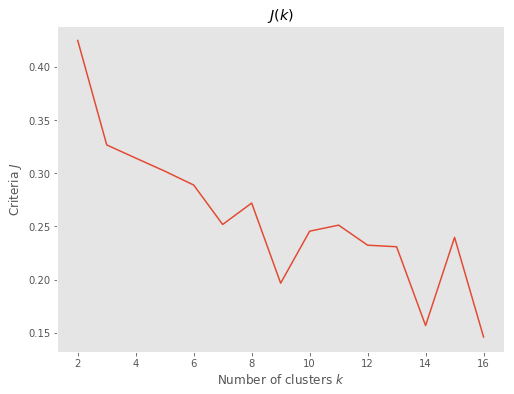

CPU times: user 3min 19s, sys: 14.6 s, total: 3min 34s
Wall time: 3min 53s


In [27]:
%time k_plot(X=X, \
    alg_name='km', \
    quality=silhouette_score, \
    k_start=2, \
    k_end=16, \
    random_state=RAND_INIT, \
    max_iter=300 \
)

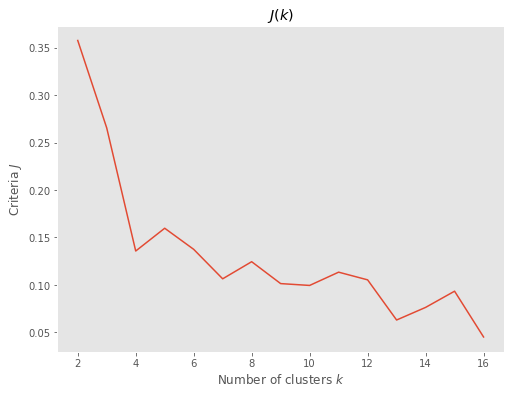

CPU times: user 8min 50s, sys: 17.6 s, total: 9min 7s
Wall time: 8min 54s


In [28]:
%time k_plot(X=X, \
    alg_name='gm', \
    quality=silhouette_score, \
    k_start=2, \
    k_end=16, \
    random_state=RAND_INIT, \
    max_iter=300 \
)

In [21]:
# db
# 0.45324793458963125
# 0.017228049478748612
%time quality(X[:10000], y[:10000])

CPU times: user 5.56 s, sys: 1.01 s, total: 6.57 s
Wall time: 5.7 s


0.017228049478748612

In [58]:
# gm
# 0.10211761067446326
# 0.13033928925836913
%time quality(X, y)

CPU times: user 5.9 s, sys: 2.13 s, total: 8.03 s
Wall time: 2min 58s


0.14139469217332198

In [34]:
# kmeans normilized
# 0.19731772479319534
# 0.23474696836911094
%time quality(X[:10000], y[:10000])

CPU times: user 6.29 s, sys: 2.08 s, total: 8.36 s
Wall time: 1min 6s


0.2886142256155253

In [52]:
# tf.idf
%time quality(X, y)

CPU times: user 6.27 s, sys: 919 ms, total: 7.19 s
Wall time: 11.4 s


0.027161106877676245

In [81]:
# normilized tf.idf
# from sklearn.metrics import silhouette_score
# silhouette_score(X, kmeans.labels_)
%time quality(X, kmeans.labels_)

CPU times: user 7.17 s, sys: 888 ms, total: 8.06 s
Wall time: 8.11 s


0.05269691015032827

In [6]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
X = tfidf_X(df_sns)
X = np.concatenate((X[:14187], X[14188:]))
df_sns = df_sns.drop(df_sns.index[14187])

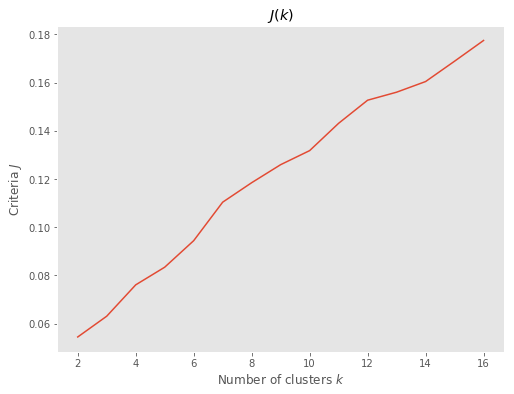

CPU times: user 2min 36s, sys: 13.3 s, total: 2min 49s
Wall time: 2min 54s


In [7]:
%time k_plot(X=X, \
    alg_name='km', \
    quality=silhouette_score, \
    k_start=2, \
    k_end=16, \
    random_state=RAND_INIT, \
    max_iter=300 \
)

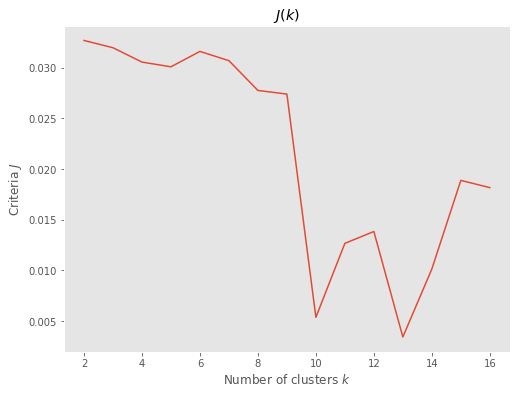

CPU times: user 7min 49s, sys: 15.7 s, total: 8min 4s
Wall time: 8min 7s


In [8]:
%time k_plot(X=X, \
    alg_name='gm', \
    quality=silhouette_score, \
    k_start=2, \
    k_end=16, \
    random_state=RAND_INIT, \
    max_iter=300 \
)

In [9]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
X = norm_tfidf_X(df_sns)
X = np.concatenate((X[:14187], X[14188:]))
df_sns = df_sns.drop(df_sns.index[14187])

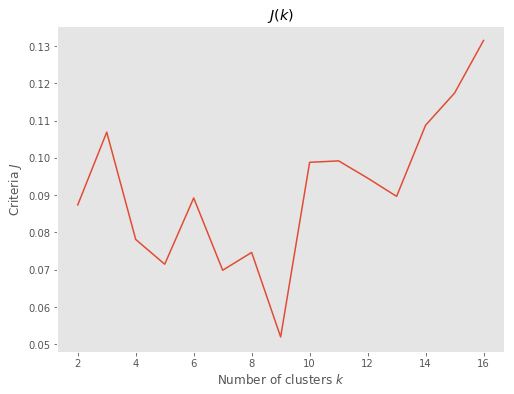

CPU times: user 2min 46s, sys: 13.5 s, total: 3min
Wall time: 3min 10s


In [10]:
%time k_plot(X=X, \
    alg_name='km', \
    quality=silhouette_score, \
    k_start=2, \
    k_end=16, \
    random_state=RAND_INIT, \
    max_iter=300 \
)

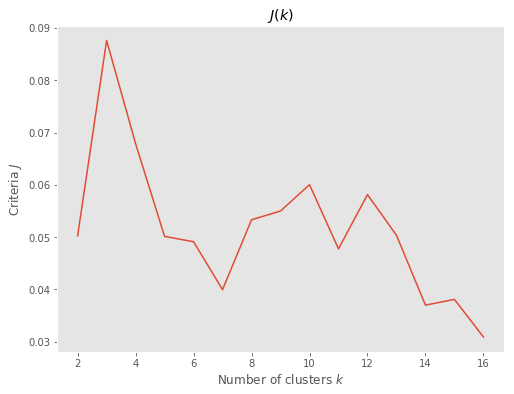

CPU times: user 6min 18s, sys: 15.2 s, total: 6min 34s
Wall time: 6min 44s


In [11]:
%time k_plot(X=X, \
    alg_name='gm', \
    quality=silhouette_score, \
    k_start=2, \
    k_end=16, \
    random_state=RAND_INIT, \
    max_iter=300 \
)

In [42]:
with open('idf.data', 'w') as f:
    np.save(f, X)
with open('idf.labels', 'w') as f:
    np.save(f, kmeans.labels_)  

## Дополнительно


In [32]:
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import gc
from sklearn.utils import shuffle

def quality(x, y):
    x, y = shuffle(x, y, random_state=RAND_INIT)    
    x = x[:10000]
    y = y[:10000]
    gc.collect()
    
    n, d = x.shape
    k = y.max() + 1
    classmasks = np.empty((k, n), dtype=bool)
    means = np.empty(n, k)
    
    dists = squareform(pdist(x))
    gc.collect()

        
    classmasks = np.array(xrange(k))[:, None] == y
    gc.collect()

    class_dists = np.array([dists[:,classmasks[i]].mean(axis=1) for i in xrange(k)])
    dists = None
    gc.collect()
    
    a_x = (class_dists * classmasks).max(axis=0)
    gc.collect()
    
    max_val = class_dists.max()
    gc.collect()
    b_x = (class_dists + (classmasks * max_val)).min(axis=0)
    
    class_dists = None
    gc.collect()
    
    sil_x = (b_x - a_x) / np.amax((a_x, b_x), axis=0)
    a_x = None
    b_x = None
    gc.collect()
    
    return sil_x.mean()

baseball


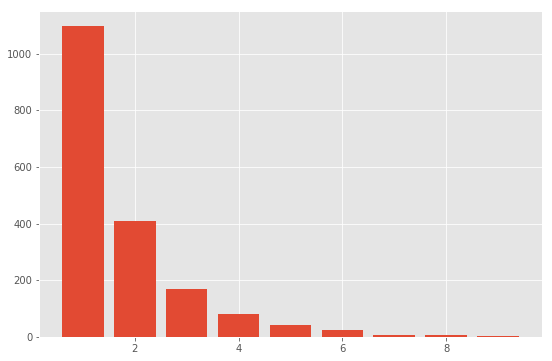

In [196]:
from IPython import display
# %pylab inline
pylab.rcParams['figure.figsize'] = (9, 6)
attrs = df_sns.columns[4:]
# fig, axs = plt.subplots(attrs.size, 1)

for i, attr in enumerate(attrs[6:7]):
    vals = df_sns[attr].values
#     plt.plot(np.linspace(0, vals.max(), 10, dtype=int), vals)
#     vals = np.sort(vals)
    bins = np.linspace(-1, vals.max(), 11, dtype=int)
    c = pd.DataFrame(vals,columns=['counts'])
    c = c.groupby(pd.cut(c['counts'], bins=bins)).counts.count()
#     c[c>100] = 100
    
#     print type(c)
#     c.plot(kind='bar', ax=axs[i])
#     c.plot(kind='bar')
    plt.bar(xrange(1,10), c.values[1:])
print attrs[7]
#     display.display(c.plot(kind='bar', ax=axs[i]))    

[  9.38900000e-01   3.65666667e-02   1.36000000e-02   5.60000000e-03
   2.70000000e-03   1.33333333e-03   8.33333333e-04   2.00000000e-04
   2.00000000e-04   6.66666667e-05]
[  9.58243524e-01   4.08722804e-02   8.71669501e-04   1.23932033e-05
   1.32152857e-07   1.12735198e-09   8.01421993e-12   4.88333134e-14
   2.60362950e-16   1.23392752e-18]


Power_divergenceResult(statistic=3756407412.3934646, pvalue=0.0)

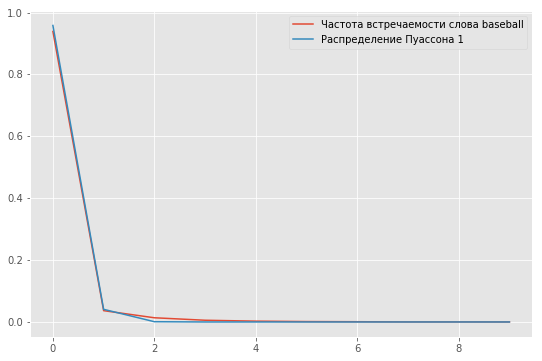

In [209]:
from scipy.stats import chisquare
from scipy.stats import norm
vals = np.array(c.values[:], dtype=np.float) / 30000
vals_m = 0.0
for i, el in enumerate(vals):
    vals_m += el * i
vals_m /= vals.sum()
# vals_m
# vals

vals2 = norm.pdf(xrange(10), vals_m)
vals2 = poisson.pmf(xrange(10), vals_m * 0.40)

# print vals
# vals = poisson.pmf(xrange(10), vals_m * 1.5)

plt.plot(xrange(10), vals, label=u'Частота встречаемости слова baseball')
plt.plot(xrange(10), vals2, label=u'Распределение Пуассона 1')
plt.legend()
# vals_m[1]
# vals2 = numpy.random.poisson(np.random.poisson(vals.mean(), 9))
print vals
print vals2
chisquare(vals, vals2)
# vals_m

In [135]:
from scipy.stats import poisson
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 1)
mu = 0.6
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')
poisson.pmf((1,2,3), 0.10663333333333333)
# x = np.arange(poisson.ppf(0.01, mu),
#               poisson.ppf(0.99, mu))
# ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
# ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

array([ 0.09584793,  0.00511029,  0.00018164])

In [60]:
# attrs = df_sns.columns[4:]
# anom = 40
# counter = 0
# for i, attr in enumerate(attrs):
#     val = df_sns.query('{} > {}'.format(attr, anom)).shape[0]
#     counter += val
# print counter
attrs = df_sns.columns[4:]
val_max = 0
i_max = 0
for i, attr in enumerate(attrs):
    val = df_sns.loc[:,attr].max()
    if val > val_max:
        val_max = val
        i_max = i
print val_max
print i_max
print attrs[i_max]
df_sns.query('{} == {}'.format(attrs[i_max], val_max)).T

39
20
god


,14283
gradyear,2007
gender,M
age,17.621
friends,43
basketball,0
football,1
soccer,0
softball,0
volleyball,0
swimming,0


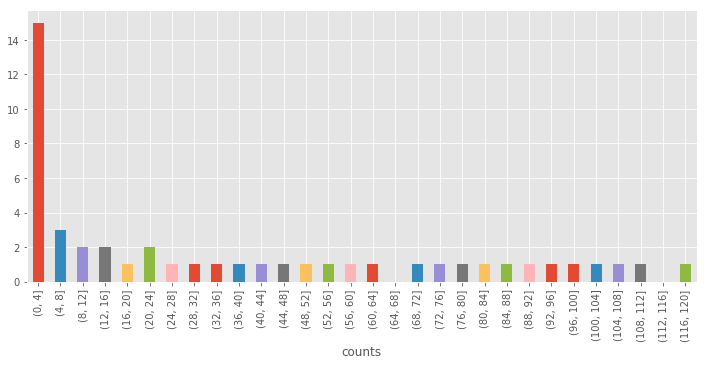

In [28]:
for i, attr in enumerate(attrs):
    counts = np.zeros(120, dtype=np.int32)
    for i in df_sns[attr].values:
        counts[i] += 1
    bins = np.linspace(0, 120, 31, dtype=int)
    c = pd.DataFrame(counts,columns=['counts'])
    c
    c = c.groupby(pd.cut(c['counts'], bins=bins)).counts.count()
    c.plot(kind='bar')
    bins

In [38]:
attrs = df_sns.columns[4:]
len_attrs = attrs.size
counts = np.empty(len_attrs, dtype=np.int32)

for i, attr in enumerate(attrs):
    val = np.sum(df_sns.loc[:,attr].values)
    counts[i] = val
#     val = df_sns.loc[:,'music'].values
#     print '{}: {}'.format(attr, val)
for i in np.argsort(counts):
    print '{}: {}'.format(attrs[i], counts[i])

bible: 640
marching: 1218
abercrombie: 1535
drugs: 1813
hollister: 2096
tennis: 2620
drunk: 2639
blonde: 2968
kissed: 3096
baseball: 3148
cheerleading: 3199
dress: 3329
jesus: 3362
death: 3427
hot: 3798
swimming: 4032
sports: 4199
sexy: 4236
volleyball: 4294
clothes: 4455
softball: 4836
die: 5523
sex: 6282
soccer: 6683
rock: 7300
church: 7445
football: 7569
mall: 7721
basketball: 8020
band: 8988
cute: 9686
shopping: 10590
hair: 12677
dance: 12755
god: 13959
music: 22135


array([    0,   862,  1724,  2586,  3448,  4310,  5172,  6034,  6896,
        7758,  8620,  9482, 10344, 11206, 12068, 12931, 13793, 14655,
       15517, 16379, 17241, 18103, 18965, 19827, 20689, 21551, 22413,
       23275, 24137, 25000])

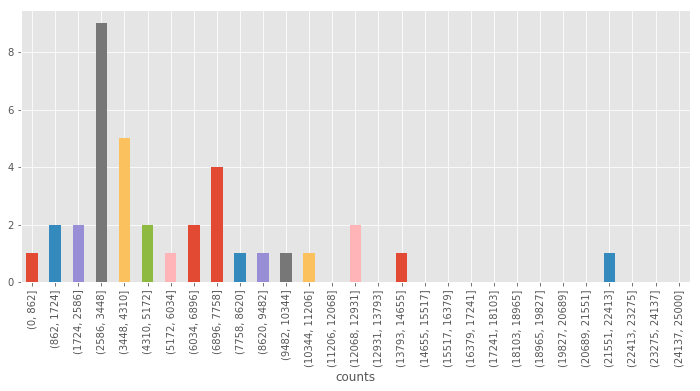

In [78]:
bins = [0,10000,20000,23000]
bins = np.linspace(0, 25000, 30, dtype=int)
c = pd.DataFrame(counts,columns=['counts'])
c
c = c.groupby(pd.cut(c['counts'], bins=bins)).counts.count()
c.plot(kind='bar')
bins

In [23]:
# for el in df_sns.columns[4:]:
#     print el
', '.join(df_sns.columns[4:])

'basketball, football, soccer, softball, volleyball, swimming, cheerleading, baseball, tennis, sports, cute, sex, sexy, hot, kissed, dance, band, marching, music, rock, god, church, jesus, bible, hair, dress, blonde, mall, shopping, clothes, hollister, abercrombie, die, death, drunk, drugs'

In [6]:
X = norm_X(df_sns)
X = np.concatenate((X[:14187], X[14188:]))
df_sns = df_sns.drop(df_sns.index[14187])